### Initializing the model

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
# Step 1: Load Data
train_data = pd.read_csv("dataset/cleaned_data_train.csv")
test_data = pd.read_csv("dataset/cleaned_dataset_test.csv") # Replace with your test dataset path

# Step 1: Label Encoding on Training Data
label_encoder = LabelEncoder()
train_data['category_encoded'] = label_encoder.fit_transform(train_data['category'])

# Step 2: Handle Missing and Unseen Categories in Test Data
test_data['category'] = test_data['category'].fillna('Unknown')

# Check for unseen categories in test data
unseen_labels = set(test_data['category']) - set(label_encoder.classes_)
if unseen_labels:
    # Append unseen labels to the existing classes
    label_encoder.classes_ = np.append(label_encoder.classes_, list(unseen_labels))

# Step 3: Transform Test Data
test_data['category_encoded'] = label_encoder.transform(test_data['category'])

# Display a sample of the test data
print(test_data.head())


                                    category  \
0  RapeGang Rape RGRSexually Abusive Content   
1                     Online Financial Fraud   
2             Cyber Attack/ Dependent Crimes   
3                     Online Financial Fraud   
4                      Any Other Cyber Crime   

                           sub_category  \
0                                   NaN   
1  DebitCredit Card FraudSim Swap Fraud   
2                         SQL Injection   
3                     Fraud CallVishing   
4                                 Other   

                                  crimeaditionalinfo  category_encoded  
0  Sir namaskar  mein Ranjit Kumar PatraPaise neh...                11  
1          KOTAK MAHINDRA BANK FRAUD\r\nFRAUD AMOUNT                 6  
2  The issue actually started when I got this ema...                 2  
3  I am amit kumar from karwi chitrakoot I am tot...                 6  
4  I have ordered  saree and  blouse from rinki s...                 0  


In [2]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [3]:
import torch
torch.cuda.empty_cache()


In [4]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current Device Index:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(0))


CUDA Available: True
Number of GPUs: 4
Current Device Index: 0
GPU Name: Tesla V100-DGXS-32GB


# Bert model

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_scheduler
import torch
from tqdm import tqdm
from torch.optim import AdamW 
# Step 1: Prepare Data
# Ensure all text columns are strings
train_data['crimeaditionalinfo'] = train_data['crimeaditionalinfo'].astype(str)
test_data['crimeaditionalinfo'] = test_data['crimeaditionalinfo'].astype(str)

# Step 2: Tokenizer (Using BERT)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Custom Dataset Class
class CrimeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Tokenize input text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

# Create datasets
train_dataset = CrimeDataset(
    train_data['crimeaditionalinfo'].tolist(),
    train_data['category_encoded'].tolist(),
    tokenizer,
)
test_dataset = CrimeDataset(
    test_data['crimeaditionalinfo'].tolist(),
    test_data['category_encoded'].tolist(),
    tokenizer,
)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Step 3: Model Setup (Using BERT)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(device)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label_encoder.classes_)
)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Step 4: Training Loop
model.train()
loss_values = []  # List to store loss values for plotting
for epoch in range(3):  # 3 epochs
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())
    
    loss_values.append(loss.item())  # Store the final loss value for each epoch

# Save the fine-tuned model and tokenizer
model_save_path = "model_bert_3epoch"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")


cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 2: 100%|██████████| 5127/5127 [11:06<00:00,  7.69it/s, loss=0.0187]


Model and tokenizer saved to model_bert_3epoch


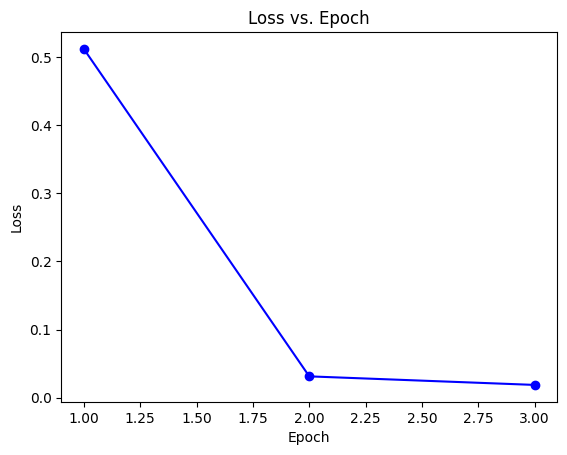

In [8]:
import matplotlib.pyplot as plt
# Plot the loss vs. epoch graph
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.show()

/home/editha/model/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.6903
Precision: 0.6155
Recall: 0.6903
F1 Score: 0.6301
Balanced Accuracy: 0.1875
AUC-ROC: Not defined (single class prediction).

Confusion Matrix:
 [[  524    31     0     0    90     0  2382     7   636     0     0     0
      0     0     0]
 [    2   101     0     0     0     0    59     0     4     0     0     0
      0     0     0]
 [    0     0     0     0   277     0    23     0   961     0     0     0
      0     0     0]
 [    8     0     0     0     1     0    26     1    16     0     0     0
      0     0     0]
 [   23     2     0     0   177     0   197     0   192     1     0     0
      0     0     0]
 [    3     0     0     0     4     0    35     1    18     0     0     0
      0     0     0]
 [  214    29     0     0    68     0 18000    11   568     0     0     0
      0     0     0]
 [    6     2     0     0     1     0    91    20    14     0     0     0
      0     0     0]
 [  135     1     0     0    82     0  1189     2  2730     0     0     0
     

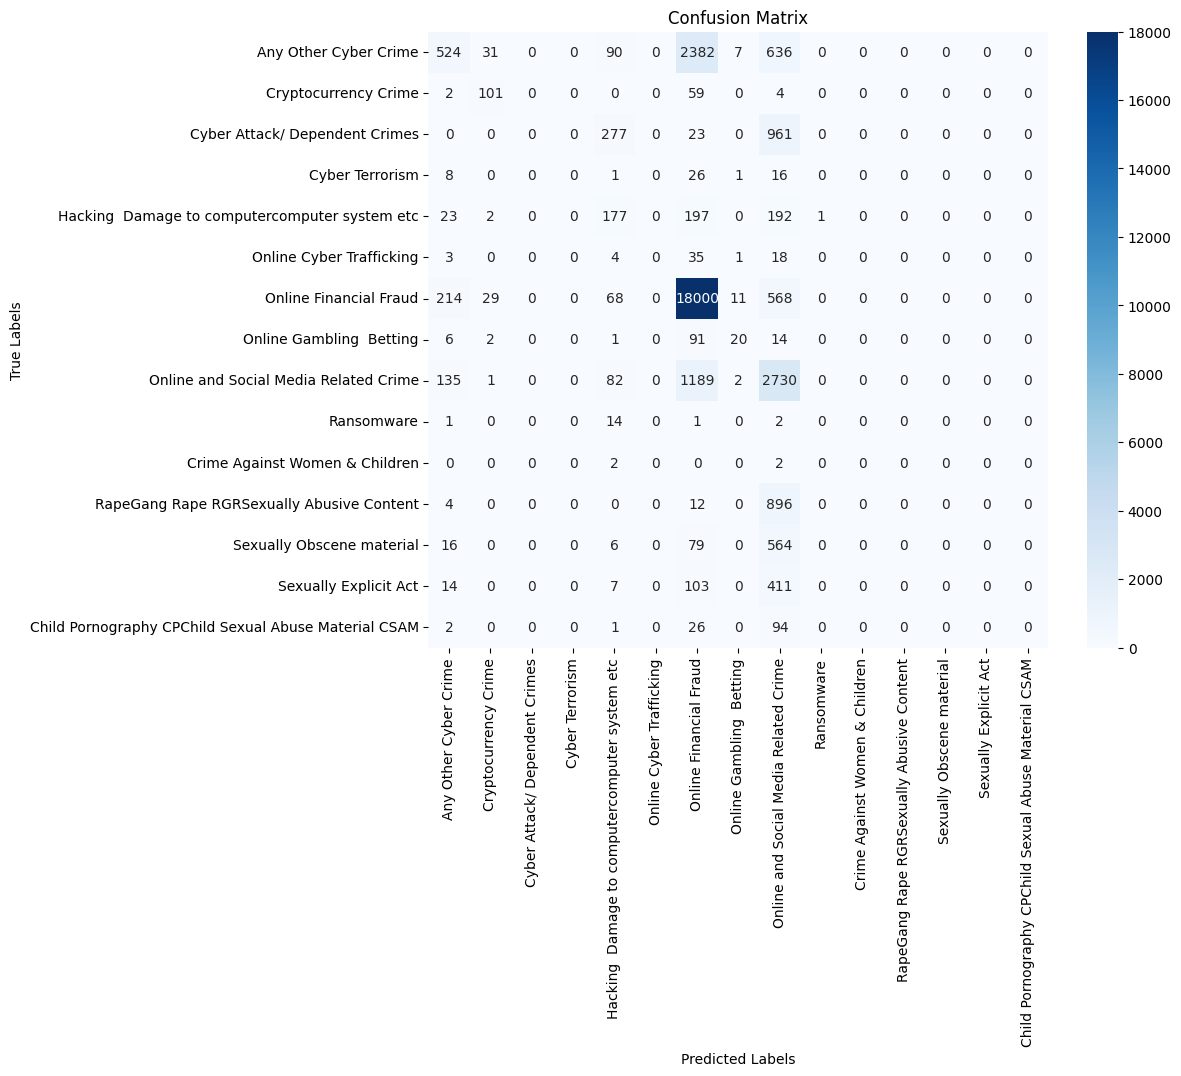

In [7]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    balanced_accuracy_score,
)
import seaborn as sns  # For Confusion Matrix Visualization
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Variables to store results
all_labels = []
all_predictions = []
all_probabilities = []  # Store probabilities for AUC-ROC calculation

# Test the model
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)  # Softmax for probabilities
        predictions = torch.argmax(logits, dim=-1)

        # Append results
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# Calculate Metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")
f1 = f1_score(all_labels, all_predictions, average="weighted")
balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

# AUC-ROC (For Multiclass, use `ovo` strategy)
try:
    auc_roc = roc_auc_score(
        all_labels, all_probabilities, multi_class="ovo", average="weighted"
    )
except ValueError:
    auc_roc = None  # Handle if only one class is predicted

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
if auc_roc is not None:
    print(f"AUC-ROC: {auc_roc:.4f}")
else:
    print("AUC-ROC: Not defined (single class prediction).")
print("\nConfusion Matrix:\n", cm)

# Generate Classification Report
# Adjust target names to match the present labels
present_labels = np.unique(all_labels)
target_names = [label_encoder.classes_[label] for label in present_labels]

report = classification_report(
    all_labels,
    all_predictions,
    target_names=target_names,
    labels=present_labels,
    zero_division=1,
)
print(report)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



### changing the lr

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_scheduler
import torch
from tqdm import tqdm
from torch.optim import AdamW 
# Step 1: Prepare Data
# Ensure all text columns are strings
train_data['crimeaditionalinfo'] = train_data['crimeaditionalinfo'].astype(str)
test_data['crimeaditionalinfo'] = test_data['crimeaditionalinfo'].astype(str)

# Step 2: Tokenizer (Using BERT)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Custom Dataset Class
class CrimeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Tokenize input text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

# Create datasets
train_dataset = CrimeDataset(
    train_data['crimeaditionalinfo'].tolist(),
    train_data['category_encoded'].tolist(),
    tokenizer,
)
test_dataset = CrimeDataset(
    test_data['crimeaditionalinfo'].tolist(),
    test_data['category_encoded'].tolist(),
    tokenizer,
)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Step 3: Model Setup (Using BERT)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(device)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label_encoder.classes_)
)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Step 4: Training Loop
model.train()
loss_values = []  # List to store loss values for plotting
for epoch in range(3):  # 3 epochs
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())
    
    loss_values.append(loss.item())  # Store the final loss value for each epoch

# Save the fine-tuned model and tokenizer
model_save_path = "model_bert_3epoch"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")


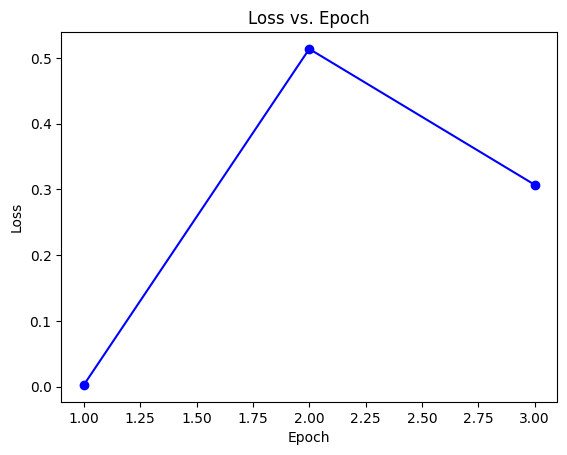

In [4]:
import matplotlib.pyplot as plt
# Plot the loss vs. epoch graph
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.show()

In [ ]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    balanced_accuracy_score,
)
import seaborn as sns  # For Confusion Matrix Visualization
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Variables to store results
all_labels = []
all_predictions = []
all_probabilities = []  # Store probabilities for AUC-ROC calculation

# Test the model
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)  # Softmax for probabilities
        predictions = torch.argmax(logits, dim=-1)

        # Append results
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# Calculate Metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")
f1 = f1_score(all_labels, all_predictions, average="weighted")
balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

# AUC-ROC (For Multiclass, use `ovo` strategy)
try:
    auc_roc = roc_auc_score(
        all_labels, all_probabilities, multi_class="ovo", average="weighted"
    )
except ValueError:
    auc_roc = None  # Handle if only one class is predicted

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
if auc_roc is not None:
    print(f"AUC-ROC: {auc_roc:.4f}")
else:
    print("AUC-ROC: Not defined (single class prediction).")
print("\nConfusion Matrix:\n", cm)

# Generate Classification Report
# Adjust target names to match the present labels
present_labels = np.unique(all_labels)
target_names = [label_encoder.classes_[label] for label in present_labels]

report = classification_report(
    all_labels,
    all_predictions,
    target_names=target_names,
    labels=present_labels,
    zero_division=1,
)
print(report)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



Accuracy: 0.6708
Precision: 0.6298
Recall: 0.6708
F1 Score: 0.6430
Balanced Accuracy: 0.2278
AUC-ROC: Not defined (single class prediction).

Confusion Matrix:
 [[ 1391    52     0     0    74     0  1352    12   789     0     0     0
      0     0     0]
 [    5   133     0     0     0     0    22     0     6     0     0     0
      0     0     0]
 [    0     0     0     0     0     0     0     0  1261     0     0     0
      0     0     0]
 [   21     1     0     0     0     0    17     0    13     0     0     0
      0     0     0]
 [  109     5     0     0   132     0   106     0   236     4     0     0
      0     0     0]
 [    6     0     0     0     4     0    25     0    26     0     0     0
      0     0     0]
 [ 1450    92     0     0    60     0 16297    17   974     0     0     0
      0     0     0]
 [   35     4     0     0     1     0    51    21    22     0     0     0
      0     0     0]
 [  444     9     0     0    59     0   658     4  2965     0     0     0
     

/home/editha/model/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### changing lr , max_length and batch size

In [7]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_scheduler
import torch
from tqdm import tqdm
from torch.optim import AdamW 
# Step 1: Prepare Data
# Ensure all text columns are strings
train_data['crimeaditionalinfo'] = train_data['crimeaditionalinfo'].astype(str)
test_data['crimeaditionalinfo'] = test_data['crimeaditionalinfo'].astype(str)

# Step 2: Tokenizer (Using BERT)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Custom Dataset Class
class CrimeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Tokenize input text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

# Create datasets
train_dataset = CrimeDataset(
    train_data['crimeaditionalinfo'].tolist(),
    train_data['category_encoded'].tolist(),
    tokenizer,
)
test_dataset = CrimeDataset(
    test_data['crimeaditionalinfo'].tolist(),
    test_data['category_encoded'].tolist(),
    tokenizer,
)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Step 3: Model Setup (Using BERT)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(device)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label_encoder.classes_)
)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=3e-5)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Step 4: Training Loop
model.train()
loss_values = []  # List to store loss values for plotting
for epoch in range(3):  # 3 epochs
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())
    
    loss_values.append(loss.item())  # Store the final loss value for each epoch

# Save the fine-tuned model and tokenizer
model_save_path = "model_bert_3epoch"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")


cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 2: 100%|██████████| 2564/2564 [18:33<00:00,  2.30it/s, loss=0.142] 


Model and tokenizer saved to model_bert_3epoch


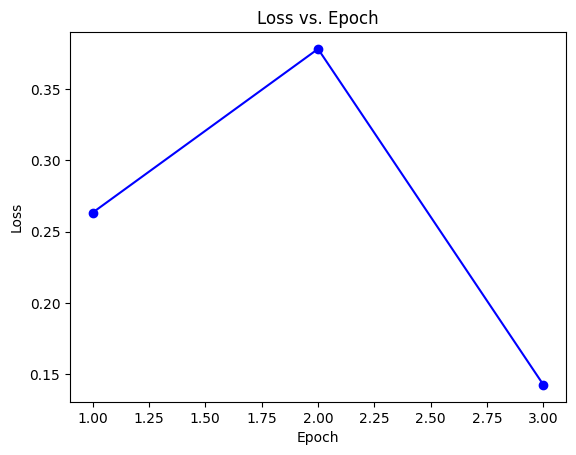

In [8]:
import matplotlib.pyplot as plt
# Plot the loss vs. epoch graph
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.show()

/home/editha/model/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.6837
Precision: 0.6218
Recall: 0.6837
F1 Score: 0.6494
Balanced Accuracy: 0.2261
AUC-ROC: Not defined (single class prediction).

Confusion Matrix:
 [[ 1236    34     0     0   124     0  1716     6   554     0     0     0
      0     0     0]
 [   11   116     0     0     0     0    37     0     2     0     0     0
      0     0     0]
 [    0     0     0     0   820     0     0     0   441     0     0     0
      0     0     0]
 [   17     1     0     0     4     0    17     0    13     0     0     0
      0     0     0]
 [   65     2     0     0   214     0   141     0   166     4     0     0
      0     0     0]
 [    9     0     0     0     4     0    26     0    22     0     0     0
      0     0     0]
 [ 1131    43     0     0    78     0 17093    15   530     0     0     0
      0     0     0]
 [   29     2     0     0     1     0    72    15    15     0     0     0
      0     0     0]
 [  428     6     0     0   122     0   914     4  2665     0     0     0
     

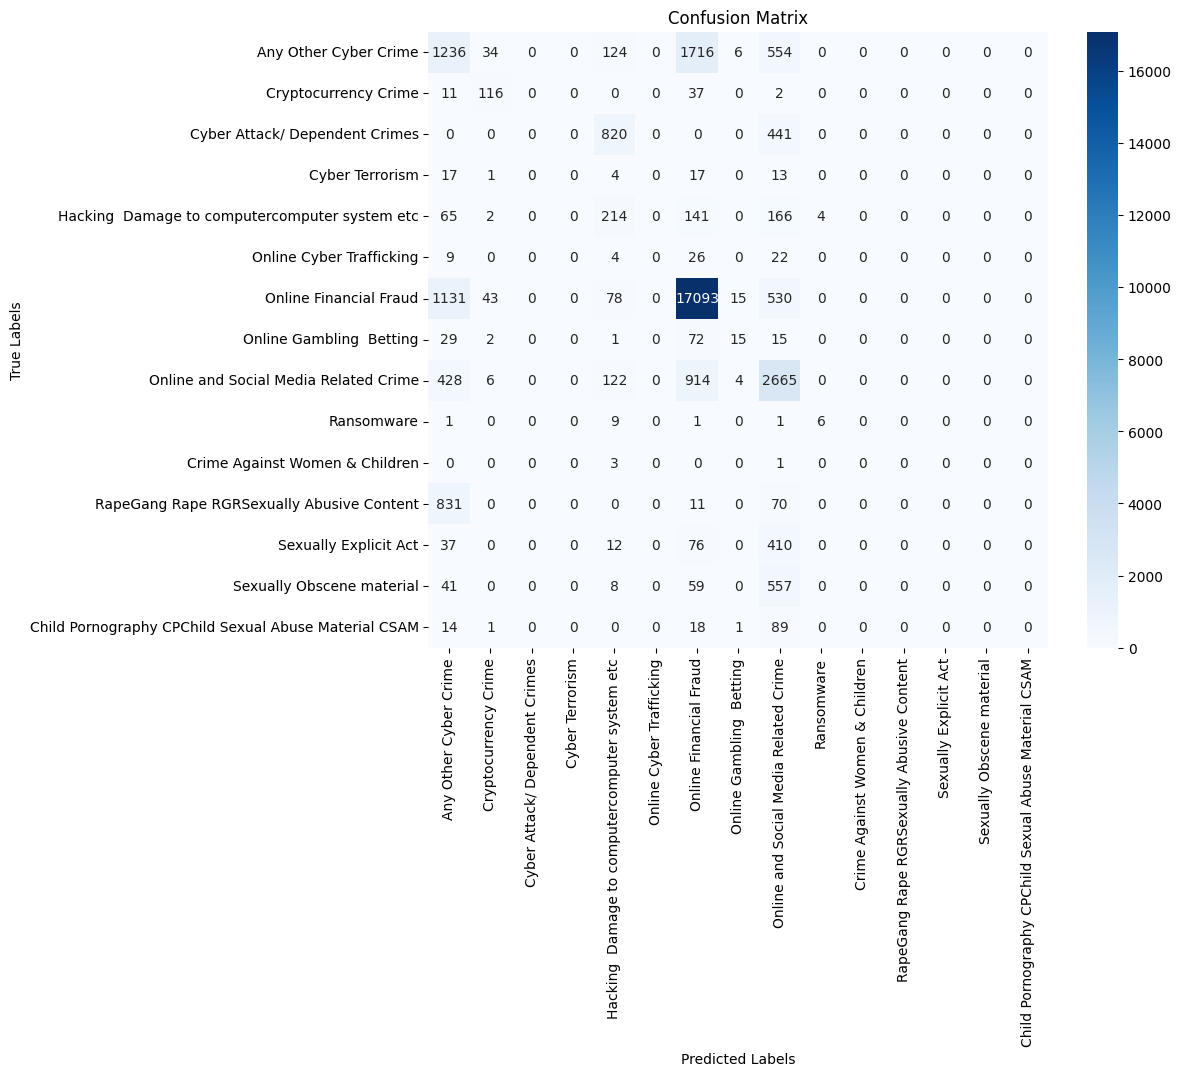

In [9]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    balanced_accuracy_score,
)
import seaborn as sns  # For Confusion Matrix Visualization
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Variables to store results
all_labels = []
all_predictions = []
all_probabilities = []  # Store probabilities for AUC-ROC calculation

# Test the model
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)  # Softmax for probabilities
        predictions = torch.argmax(logits, dim=-1)

        # Append results
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# Calculate Metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")
f1 = f1_score(all_labels, all_predictions, average="weighted")
balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

# AUC-ROC (For Multiclass, use `ovo` strategy)
try:
    auc_roc = roc_auc_score(
        all_labels, all_probabilities, multi_class="ovo", average="weighted"
    )
except ValueError:
    auc_roc = None  # Handle if only one class is predicted

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
if auc_roc is not None:
    print(f"AUC-ROC: {auc_roc:.4f}")
else:
    print("AUC-ROC: Not defined (single class prediction).")
print("\nConfusion Matrix:\n", cm)

# Generate Classification Report
# Adjust target names to match the present labels
present_labels = np.unique(all_labels)
target_names = [label_encoder.classes_[label] for label in present_labels]

report = classification_report(
    all_labels,
    all_predictions,
    target_names=target_names,
    labels=present_labels,
    zero_division=1,
)
print(report)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



### trying bert for the 1st time

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

# Step 1: Prepare Data
# Ensure all text columns are strings
train_data['crimeaditionalinfo'] = train_data['crimeaditionalinfo'].astype(str)
test_data['crimeaditionalinfo'] = test_data['crimeaditionalinfo'].astype(str)

# Step 2: Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Custom Dataset Class
class CrimeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Tokenize input text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

# Create datasets
train_dataset = CrimeDataset(
    train_data['crimeaditionalinfo'].tolist(),
    train_data['category_encoded'].tolist(),
    tokenizer,
)
test_dataset = CrimeDataset(
    test_data['crimeaditionalinfo'].tolist(),
    test_data['category_encoded'].tolist(),
    tokenizer,
)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Step 3: Model Setup
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label_encoder.classes_)
)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Step 4: Training Loop
model.train()
for epoch in range(3):  # 3 epochs
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

# Save the Model
model.save_pretrained("bert_model")
tokenizer.save_pretrained("bert_model")


/home/editha/model/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 0:   4%|▍         | 222/5127 [00:29<10:34,  7.73it/s, loss=0.534]

Epoch 2: 100%|██████████| 5127/5127 [11:04<00:00,  7.72it/s, loss=0.325] 


('bert_model/tokenizer_config.json',
 'bert_model/special_tokens_map.json',
 'bert_model/vocab.txt',
 'bert_model/added_tokens.json')

In [7]:
from sklearn.metrics import classification_report

# Step 5: Evaluation
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Debug mismatches
unique_test_labels = set(all_labels)
unique_predicted_labels = set(all_predictions)

# Generate classification report
labels = range(len(label_encoder.classes_))  # Ensure alignment
report = classification_report(
    all_labels,
    all_predictions,
    labels=labels,
    target_names=label_encoder.classes_,
    zero_division=1  # Suppress undefined metric warnings
)
print(report)


                                                      precision    recall  f1-score   support

                               Any Other Cyber Crime       0.32      0.20      0.25      3670
                                Cryptocurrency Crime       0.58      0.51      0.54       166
                      Cyber Attack/ Dependent Crimes       0.98      0.90      0.93      1261
                                     Cyber Terrorism       1.00      0.00      0.00        52
      Hacking  Damage to computercomputer system etc       0.55      0.10      0.17       592
                            Online Cyber Trafficking       1.00      0.00      0.00        61
                              Online Financial Fraud       0.82      0.95      0.88     18890
                            Online Gambling  Betting       0.47      0.11      0.18       134
               Online and Social Media Related Crime       0.50      0.66      0.57      4139
                                          Ransomware       

### changing the number of epochs from 3 to 5

In [7]:
# Step 1: Prepare Data
# Ensure all text columns are strings
train_data['crimeaditionalinfo'] = train_data['crimeaditionalinfo'].astype(str)
test_data['crimeaditionalinfo'] = test_data['crimeaditionalinfo'].astype(str)

# Step 2: Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Custom Dataset Class
class CrimeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Tokenize input text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

# Create datasets
train_dataset = CrimeDataset(
    train_data['crimeaditionalinfo'].tolist(),
    train_data['category_encoded'].tolist(),
    tokenizer,
)
test_dataset = CrimeDataset(
    test_data['crimeaditionalinfo'].tolist(),
    test_data['category_encoded'].tolist(),
    tokenizer,
)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Step 3: Model Setup
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(device)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label_encoder.classes_)
)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 5  # 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Step 4: Training Loop
model.train()
loss_values = []  # List to store loss values for plotting
for epoch in range(5):  # 3 epochs
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())
    
    loss_values.append(loss.item())  # Store the final loss value for each epoch

# Save the fine-tuned model and tokenizer
model_save_path = "model_bert_5epoch"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")


cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 4: 100%|██████████| 2564/2564 [12:05<00:00,  3.53it/s, loss=0.0906]


Model and tokenizer saved to model_bert_5epoch


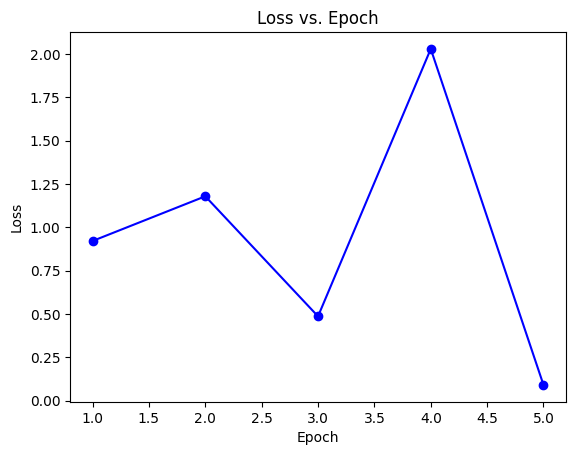

In [8]:
# Plot the loss vs. epoch graph
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.show()

In [12]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    balanced_accuracy_score,
)
import seaborn as sns  # For Confusion Matrix Visualization
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Variables to store results
all_labels = []
all_predictions = []
all_probabilities = []  # Store probabilities for AUC-ROC calculation

# Test the model
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)  # Softmax for probabilities
        predictions = torch.argmax(logits, dim=-1)

        # Append results
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# Calculate Metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")
f1 = f1_score(all_labels, all_predictions, average="weighted")
balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

# AUC-ROC (For Multiclass, use `ovo` strategy)
try:
    auc_roc = roc_auc_score(
        all_labels, all_probabilities, multi_class="ovo", average="weighted"
    )
except ValueError:
    auc_roc = None  # Handle if only one class is predicted

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
if auc_roc is not None:
    print(f"AUC-ROC: {auc_roc:.4f}")
else:
    print("AUC-ROC: Not defined (single class prediction).")
print("\nConfusion Matrix:\n", cm)

# Generate Classification Report
# Adjust target names to match the present labels
present_labels = np.unique(all_labels)
target_names = [label_encoder.classes_[label] for label in present_labels]

report = classification_report(
    all_labels,
    all_predictions,
    target_names=target_names,
    labels=present_labels,
    zero_division=1,
)
print(report)


Accuracy: 0.7049
Precision: 0.6633
Recall: 0.7049
F1 Score: 0.6784
Balanced Accuracy: 0.2451
AUC-ROC: Not defined (single class prediction).

Confusion Matrix:
 [[ 1055    20     0     0    68     0  1745    15   767     0     0     0
      0     0     0]
 [    7    90     0     0     3     0    50     8     8     0     0     0
      0     0     0]
 [    0     0   894     0    22     0     7     0   338     0     0     0
      0     0     0]
 [    7     0     0     2     1     0    24     0    18     0     0     0
      0     0     0]
 [   98     2     0     1   159     0   145     1   186     0     0     0
      0     0     0]
 [    7     0     0     0     5     0    27     0    22     0     0     0
      0     0     0]
 [  937    23     0     0    63     0 16878    36   953     0     0     0
      0     0     0]
 [   26     0     0     0     2     0    62    24    20     0     0     0
      0     0     0]
 [  330     1     0     0    75     0   819     8  2906     0     0     0
     

/home/editha/model/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


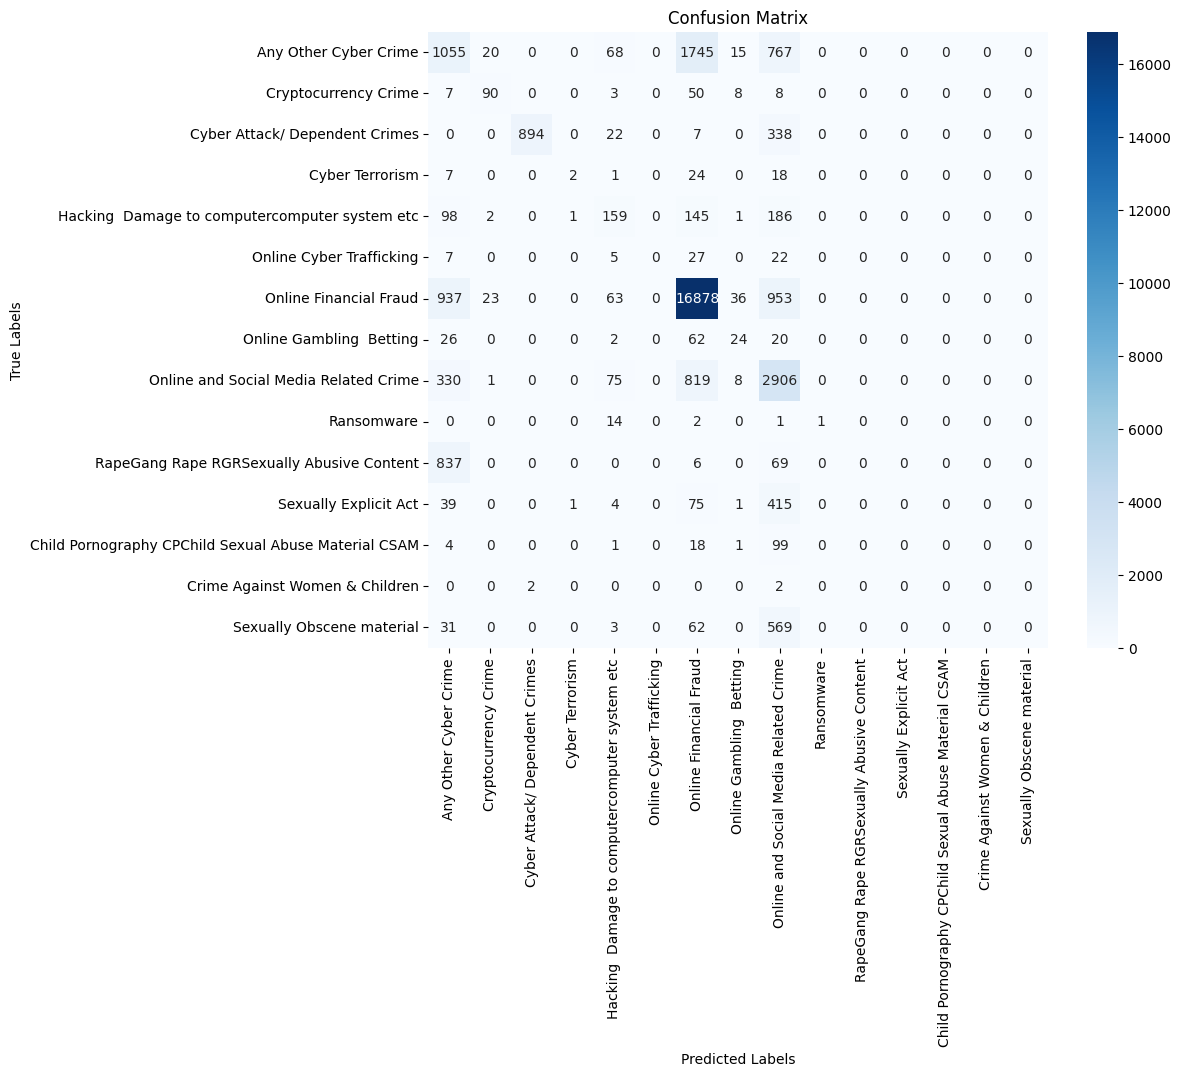

In [13]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


# DistillBERT Model

In [3]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_scheduler
import torch
from tqdm import tqdm

# Step 1: Prepare Data
# Ensure all text columns are strings
train_data['crimeaditionalinfo'] = train_data['crimeaditionalinfo'].astype(str)
test_data['crimeaditionalinfo'] = test_data['crimeaditionalinfo'].astype(str)

# Step 2: Tokenizer (Using DistilBERT)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Custom Dataset Class
class CrimeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Tokenize input text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

# Create datasets
train_dataset = CrimeDataset(
    train_data['crimeaditionalinfo'].tolist(),
    train_data['category_encoded'].tolist(),
    tokenizer,
)
test_dataset = CrimeDataset(
    test_data['crimeaditionalinfo'].tolist(),
    test_data['category_encoded'].tolist(),
    tokenizer,
)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Step 3: Model Setup (Using DistilBERT)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(label_encoder.classes_)
)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_training_steps = len(train_loader) * 5  # 5 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Step 4: Training Loop
model.train()
loss_values = []  # List to store loss values for plotting
for epoch in range(5):  # 5 epochs
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())
    
    loss_values.append(loss.item())  # Store the final loss value for each epoch

# Save the fine-tuned model and tokenizer
model_save_path = "model_distilbert_3epoch"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")


cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/editha/model/.venv/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 4: 100%|██████████| 2564/2564 [05:59<00:00,  7.13it/s, loss=0.0236]


Model and tokenizer saved to model_distilbert_3epoch


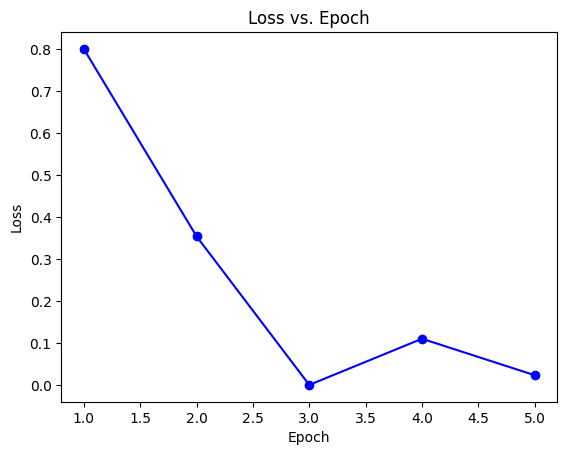

In [5]:
import matplotlib.pyplot as plt
# Plot the loss vs. epoch graph
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.show()

/home/editha/model/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.6687
Precision: 0.6212
Recall: 0.6687
F1 Score: 0.6400
Balanced Accuracy: 0.2169
AUC-ROC: Not defined (single class prediction).

Confusion Matrix:
 [[ 1161    22     0     0   133     0  1566     8   780     0     0     0
      0     0     0]
 [   24   102     0     0     0     0    33     0     7     0     0     0
      0     0     0]
 [    0     0     0     0   784     0    47     0   430     0     0     0
      0     0     0]
 [   12     0     0     0     3     0    22     0    15     0     0     0
      0     0     0]
 [   79     2     0     0   234     0   110     0   163     4     0     0
      0     0     0]
 [    2     0     0     0     6     0    23     1    29     0     0     0
      0     0     0]
 [ 1103    30     0     1    94     0 16542    15  1105     0     0     0
      0     0     0]
 [   26     2     0     0     2     0    56    20    28     0     0     0
      0     0     0]
 [  373     2     0     1   200     0   741     6  2816     0     0     0
     

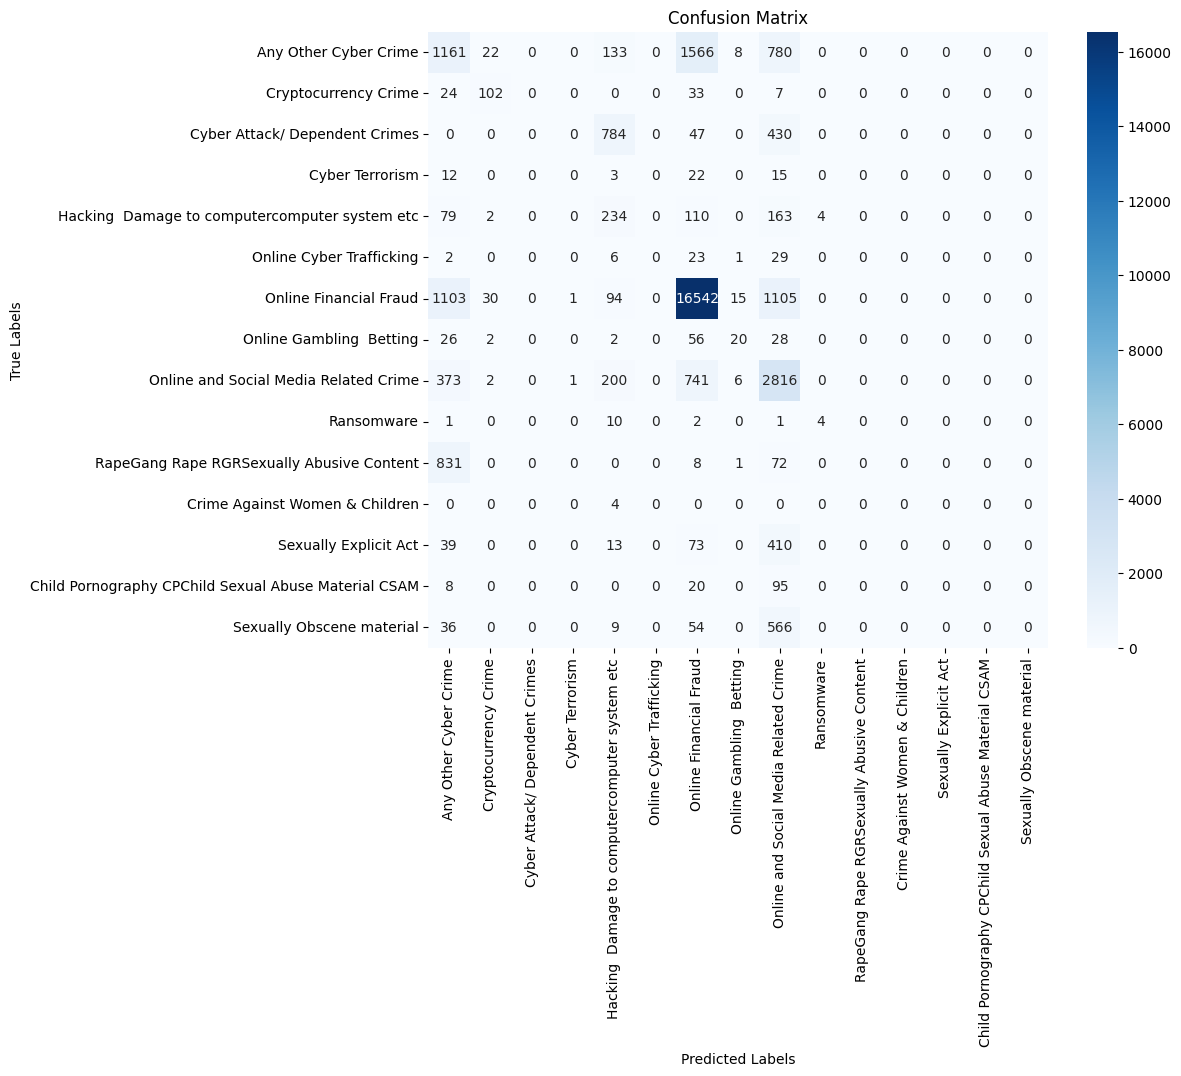

In [6]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    balanced_accuracy_score,
)
import seaborn as sns  # For Confusion Matrix Visualization
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Variables to store results
all_labels = []
all_predictions = []
all_probabilities = []  # Store probabilities for AUC-ROC calculation

# Test the model
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)  # Softmax for probabilities
        predictions = torch.argmax(logits, dim=-1)

        # Append results
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# Calculate Metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")
f1 = f1_score(all_labels, all_predictions, average="weighted")
balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

# AUC-ROC (For Multiclass, use `ovo` strategy)
try:
    auc_roc = roc_auc_score(
        all_labels, all_probabilities, multi_class="ovo", average="weighted"
    )
except ValueError:
    auc_roc = None  # Handle if only one class is predicted

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
if auc_roc is not None:
    print(f"AUC-ROC: {auc_roc:.4f}")
else:
    print("AUC-ROC: Not defined (single class prediction).")
print("\nConfusion Matrix:\n", cm)

# Generate Classification Report
# Adjust target names to match the present labels
present_labels = np.unique(all_labels)
target_names = [label_encoder.classes_[label] for label in present_labels]

report = classification_report(
    all_labels,
    all_predictions,
    target_names=target_names,
    labels=present_labels,
    zero_division=1,
)
print(report)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



# RoBERTa Model

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_scheduler
import torch
from tqdm import tqdm

# Step 1: Prepare Data
# Ensure all text columns are strings
train_data['crimeaditionalinfo'] = train_data['crimeaditionalinfo'].astype(str)
test_data['crimeaditionalinfo'] = test_data['crimeaditionalinfo'].astype(str)

# Step 2: Tokenizer (Using RoBERTa)
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Custom Dataset Class
class CrimeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Tokenize input text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

# Create datasets
train_dataset = CrimeDataset(
    train_data['crimeaditionalinfo'].tolist(),
    train_data['category_encoded'].tolist(),
    tokenizer,
)
test_dataset = CrimeDataset(
    test_data['crimeaditionalinfo'].tolist(),
    test_data['category_encoded'].tolist(),
    tokenizer,
)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Step 3: Model Setup (Using RoBERTa)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(device)
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=len(label_encoder.classes_)
)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # 5 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Step 4: Training Loop
model.train()
loss_values = []  # List to store loss values for plotting
for epoch in range(3):  # 5 epochs
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())
    
    loss_values.append(loss.item())  # Store the final loss value for each epoch

# Save the fine-tuned model and tokenizer
model_save_path = "model_roberta_3epoch"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")


cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/editha/model/.venv/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 2: 100%|██████████| 2564/2564 [12:06<00:00,  3.53it/s, loss=0.552]


Model and tokenizer saved to model_roberta_5epoch


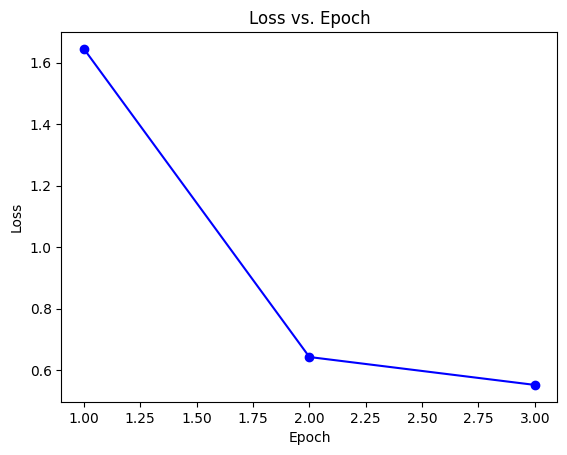

In [15]:
# Plot the loss vs. epoch graph
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.show()

/home/editha/model/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.6638
Precision: 0.6100
Recall: 0.6638
F1 Score: 0.6324
Balanced Accuracy: 0.1946
AUC-ROC: Not defined (single class prediction).

Confusion Matrix:
 [[ 1576    39     0     0    32     0  1640     2   381     0     0     0
      0     0     0]
 [    5   120     0     0     1     0    39     0     1     0     0     0
      0     0     0]
 [  141     0     0     0    86     0    61     0   973     0     0     0
      0     0     0]
 [   24     1     0     0     0     0    17     0    10     0     0     0
      0     0     0]
 [  163     5     0     0    94     0   198     1   130     1     0     0
      0     0     0]
 [   11     0     0     0     2     0    34     0    14     0     0     0
      0     0     0]
 [ 1953    74     0     0    16     0 16545     6   296     0     0     0
      0     0     0]
 [   29     3     0     0     0     0    87     6     9     0     0     0
      0     0     0]
 [  766    10     0     0    36     0   943     1  2383     0     0     0
     

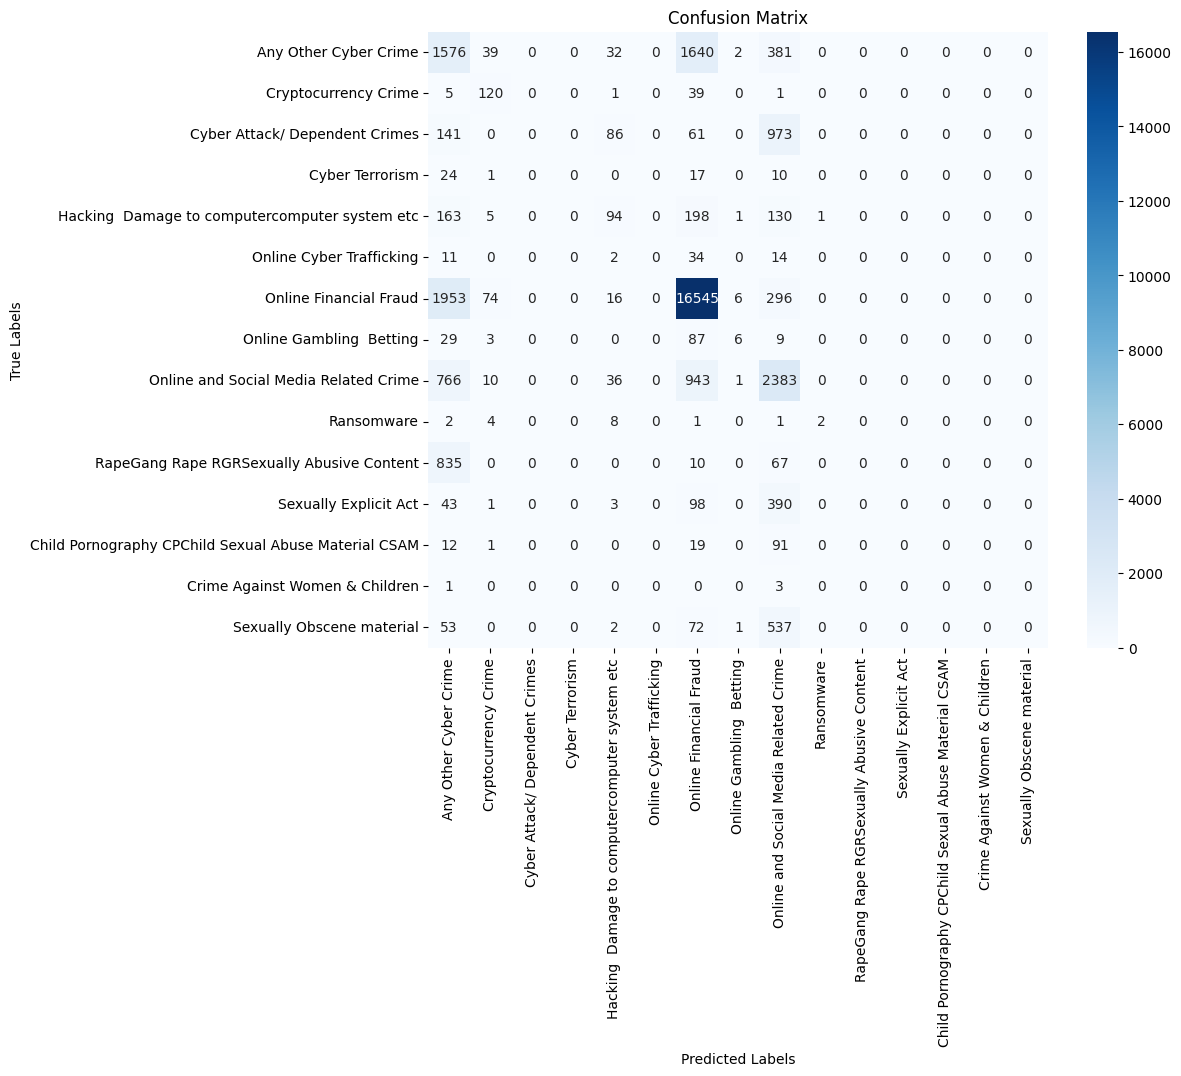

In [16]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    balanced_accuracy_score,
)
import seaborn as sns  # For Confusion Matrix Visualization
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Variables to store results
all_labels = []
all_predictions = []
all_probabilities = []  # Store probabilities for AUC-ROC calculation

# Test the model
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)  # Softmax for probabilities
        predictions = torch.argmax(logits, dim=-1)

        # Append results
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# Calculate Metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")
f1 = f1_score(all_labels, all_predictions, average="weighted")
balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

# AUC-ROC (For Multiclass, use `ovo` strategy)
try:
    auc_roc = roc_auc_score(
        all_labels, all_probabilities, multi_class="ovo", average="weighted"
    )
except ValueError:
    auc_roc = None  # Handle if only one class is predicted

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
if auc_roc is not None:
    print(f"AUC-ROC: {auc_roc:.4f}")
else:
    print("AUC-ROC: Not defined (single class prediction).")
print("\nConfusion Matrix:\n", cm)

# Generate Classification Report
# Adjust target names to match the present labels
present_labels = np.unique(all_labels)
target_names = [label_encoder.classes_[label] for label in present_labels]

report = classification_report(
    all_labels,
    all_predictions,
    target_names=target_names,
    labels=present_labels,
    zero_division=1,
)
print(report)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



# xlnet model

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

# Step 1: Prepare Data
# Ensure all text columns are strings
train_data['crimeaditionalinfo'] = train_data['crimeaditionalinfo'].astype(str)
test_data['crimeaditionalinfo'] = test_data['crimeaditionalinfo'].astype(str)

# Step 2: Tokenizer
model_name = "xlnet-base-cased"  # XLNet model
tokenizer = XLNetTokenizer.from_pretrained(model_name)

# Custom Dataset Class
class CrimeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Tokenize input text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

# Create datasets
train_dataset = CrimeDataset(
    train_data['crimeaditionalinfo'].tolist(),
    train_data['category_encoded'].tolist(),
    tokenizer,
)
test_dataset = CrimeDataset(
    test_data['crimeaditionalinfo'].tolist(),
    test_data['category_encoded'].tolist(),
    tokenizer,
)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Step 3: Model Setup
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = XLNetForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_encoder.classes_)
)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Step 4: Training Loop
model.train()
for epoch in range(3):  # 3 epochs
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

# Save the Fine-Tuned Model
model_save_path = "xlnet_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model and tokenizer saved to {model_save_path}")


/home/editha/model/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 2: 100%|██████████| 5127/5127 [13:04<00:00,  6.54it/s, loss=0.071] 


Model and tokenizer saved to xlnet_model


In [3]:
from sklearn.metrics import classification_report

# Step 5: Evaluation
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Debug mismatches
unique_test_labels = set(all_labels)
unique_predicted_labels = set(all_predictions)

# Generate classification report
labels = range(len(label_encoder.classes_))  # Ensure alignment
report = classification_report(
    all_labels,
    all_predictions,
    labels=labels,
    target_names=label_encoder.classes_,
    zero_division=1  # Suppress undefined metric warnings
)
print(report)


                                                      precision    recall  f1-score   support

                               Any Other Cyber Crime       0.49      0.18      0.26      3670
                                Cryptocurrency Crime       0.47      0.52      0.49       166
                      Cyber Attack/ Dependent Crimes       1.00      0.19      0.32      1261
                                     Cyber Terrorism       1.00      0.00      0.00        52
      Hacking  Damage to computercomputer system etc       0.12      0.09      0.10       592
                            Online Cyber Trafficking       1.00      0.00      0.00        61
                              Online Financial Fraud       0.79      0.95      0.87     18890
                            Online Gambling  Betting       1.00      0.00      0.00       134
               Online and Social Media Related Crime       0.42      0.63      0.50      4139
                                          Ransomware       